# -> My opinion on your first model 

Basically you a following a single player point of view, and computing the outcome of the game from this specific player perspective. I think this is ill-defined. This implicitly bias the probability of winning toward the enemy team, since one can expect that there is an higher probability of better player in the enemy team.

I'll distinguish between percentile and winrate : 

* $pc$ is your position in the ladder, it is defined between 0 and 1, and to match your hypothesis i'll state it is uniformly distributed, this mean that there is the same density of player at each percentile (which is presumably false, but i'll get to that latter)
* $wr$ is the (number of wins / number of games) for an infinite number of games

The number of better players for a given percentile is basically a binomial distribution, and so in your team there are 4 draws (Number of expected better player = $4*(1-pc)$), and in the other team there are five (Number of expected better player = $5*(1-pc)$). With this setup, it is impossible to get fair match, even if you are the best player in the world. For an ultra-high percentile player, there will only be situation of 4 worse teammates vs 5 worse opponents, which lead to "fair" matches in the sense you consider that the win is given to the team with the higher number of better players compared to your specific player perspective. Since it will be 0BP vs 0BP, this will 50% $wr$ for the best player in the world, which is not what is observed ([best players systematically have $wr>0.5$](https://www.leagueofgraphs.com/rankings/summoners) , even when excluding MMR boosted accounts or w/e trickery you can think of). This really comes from the fact that in your set-up, you investigate a subjective pov, with a selected player that will serve as pivot to determine either you win or lose, and whose contribution to the outcome of the game is not considered at all from a mathematical perspective.

At first I'll try to recover your results using a (slightly) different methodology, instead of computing the probabilities, I'll do Monte Carlo simulations so I don't have to do any maths. I'll compute the number of better player in each team, compare it, and return win if ally team has more BP, loss if enemy has more BP, and win/loss with a 50%/50% probability if there is the same number of BP. If I understood well, this should return the same winrate as yours, and + I do a small bootstrap to estimate the error arising from the finite number of simulations. 

In [1]:
import numpy as np 
from numpy.random import default_rng

rng = default_rng()

def simulate_winrate_basic(percentile, n_simulations=int(1e6)):
    """
    This should emulate your model
    
    :param percentile: percentile of the player
    :param n_simulations: number of simulated match 
    :return: (winrate, error on winrate)
    """
    ally_team_bp = rng.binomial(4, 1-percentile, size=n_simulations)
    enemy_team_bp = rng.binomial(5, 1-percentile, size=n_simulations)
    
    wins = np.where(ally_team_bp == enemy_team_bp, rng.binomial(1, 0.5, size=n_simulations), ally_team_bp>enemy_team_bp)
    
    splitted = np.array_split(wins, 50)
    winrates = [np.sum(x)/len(x) for x in splitted]
    
    return np.mean(winrates), np.std(winrates)

Let's compare to the 3 cases highlighted in your doc with 100 000 000 simulations

In [2]:
from tqdm.notebook import tqdm

percentiles = [0.53, 0.98, 0.99999]

for percentile in tqdm(percentiles):
    winrate, winrate_err = simulate_winrate_basic(percentile, n_simulations=int(1e8))
    print(f'Percentile : {percentile} -> Winrate : {winrate} +- {winrate_err}')

  0%|          | 0/3 [00:00<?, ?it/s]

Percentile : 0.53 -> Winrate : 0.38417022 +- 0.00038182149179950673
Percentile : 0.98 -> Winrate : 0.4907437000000001 +- 0.00040148570335692276
Percentile : 0.99999 -> Winrate : 0.50007105 +- 0.00037447074985904867


It seems to approximately work ! I am recovering your winrates within uncertainty, so this is promising! I only get a systematic 2% bias when comparing to your 98 percentile player. Be aware that I don't like bootstrap since it is a quick and dirty way to obtain error bars. I make here a small function to draw $wr$ vs $pc$ for a given simulator. 

In [3]:
import matplotlib.pyplot as plt

def plot_simulation(simulate_winrate, n_simulations=10000, n_steps=30, **extra_kwargs):

    percentiles = np.linspace(0, 1, n_steps)
    winrates = np.empty_like(percentiles)
    winrates_err = np.empty_like(percentiles)
    
    for i, percentile in enumerate(tqdm(percentiles)):
        
        winrates[i], winrates_err[i] = simulate_winrate(percentile, n_simulations=n_simulations, **extra_kwargs)
    
    plt.errorbar(percentiles, winrates, yerr=winrates_err, fmt='None')
    plt.ylabel('Expected winrate')
    plt.xlabel("Player's percentile")

Note here how the uncertainties shrink with an increasing number of simulations. 

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

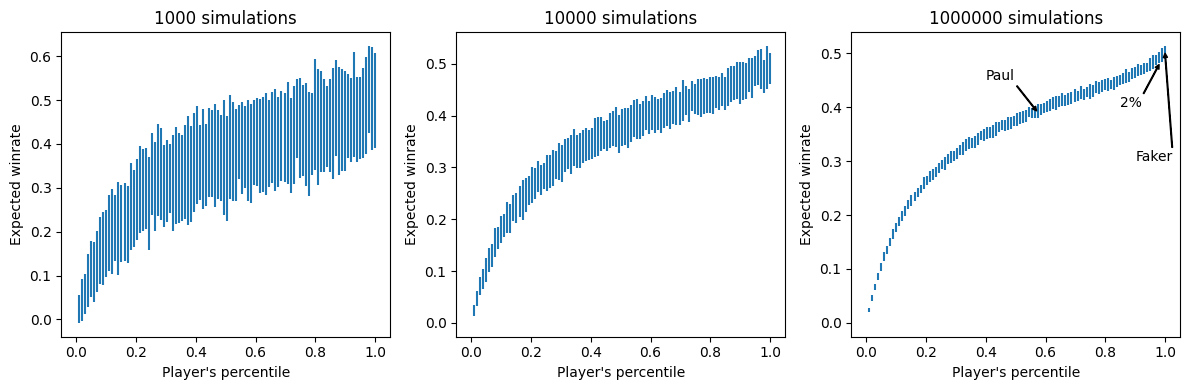

In [4]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('1000 simulations')
plot_simulation(simulate_winrate_basic, n_simulations=1000, n_steps=100)
plt.subplot(132)
plt.title('10000 simulations')
plot_simulation(simulate_winrate_basic, n_simulations=10000, n_steps=100)
plt.subplot(133)
plt.title('1000000 simulations')
plot_simulation(simulate_winrate_basic, n_simulations=100000, n_steps=100)
arrowprops = dict(facecolor='black', width=0.5, headwidth=3, headlength=3)
plt.annotate('Paul', xy=(0.57, .393264), xytext=(0.4, 0.45), arrowprops=arrowprops)
plt.annotate('2%', xy=(0.98, .4791), xytext=(0.85, 0.4), arrowprops=arrowprops)
plt.annotate('Faker', xy=(0.99999, .49999), xytext=(0.9, 0.3), arrowprops=arrowprops)
plt.tight_layout()

I'll consider that I got the same results as yours, using the same hypothesis you made, great! We are consistent. But still literally no one has a winrate >50%, which is IMPOSSIBLE in a closed environment where the same players are matching one against another, this should be symetric at some point. I am convinced that this arises because of your formulation of winning/losing, which inherently bias the ally team. 

# -> Include the pivot player when determining the outcome

Okay so now, I'll try to include your player in the win determination. My take on this would be to draw a percentile for each player in the vincinity of your pivot player's percentile. At first, I'll just assume a uniform player distribution as you did, and do the following simulations. Note that I am clipping the distributions to 0 and 1, since you cannot draw a better player than the 1st or a worse than the last in your team. So the setup is the following : 
* you are matched with/against players of percentile drawn from a uniform distribution define over the reference player $pc$ +- a given vicinity 
* you win if the average percentile of your team is greater than the ennemy team
* I am not accounting for the edgecase of teams getting the perfectly same average percentile since it is very unlikely to occurs with float64

In [5]:
def simulate_winrate_uniform_percentile(percentile, n_simulations=int(1e6), vicinity=0.05):
    """
    This includes the player in final determination
    
    :param percentile: percentile of the player
    :param n_simulations: number of simulated match 
    :return: (winrate, error on winrate)
    """
    ally_team_percentile = rng.uniform(low=max(0, percentile-vicinity),
                                        high=min(1, percentile+vicinity),
                                        size=(5, n_simulations))
    
    # I force the first player to have the percentile of your focus player
    ally_team_percentile[0, : ] = percentile
    
    enemy_team_percentile = rng.uniform(low=max(0, percentile-vicinity),
                                        high=min(1, percentile+vicinity),
                                        size=(5, n_simulations))
    
    wins = np.mean(ally_team_percentile, axis=0) > np.mean(enemy_team_percentile, axis=0)
    
    splitted = np.array_split(wins, 50)
    winrates = [np.sum(x)/len(x) for x in splitted]
    
    return np.mean(winrates), np.std(winrates)

Let's illustrate this ! 

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

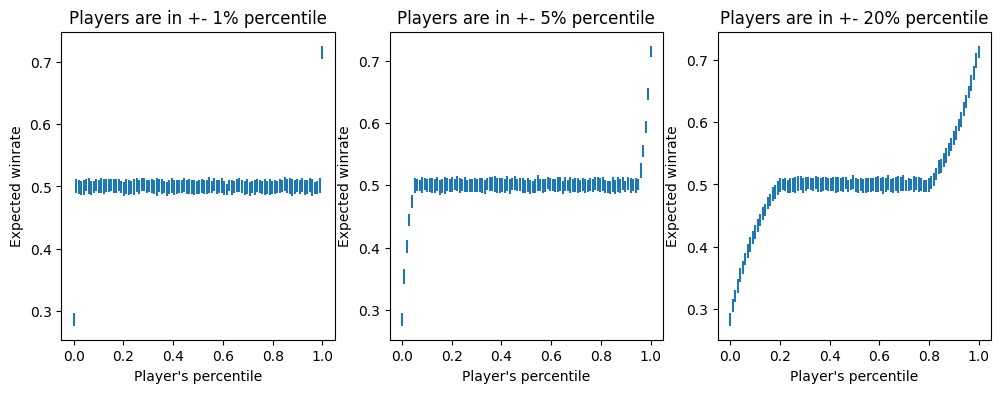

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('Players are in +- 1% percentile')
plot_simulation(simulate_winrate_uniform_percentile, n_simulations=100000, n_steps=100, vicinity=0.01)
plt.subplot(132)
plt.title('Players are in +- 5% percentile')
plot_simulation(simulate_winrate_uniform_percentile, n_simulations=100000, n_steps=100, vicinity=0.05)
plt.subplot(133)
plt.title('Players are in +- 20% percentile')
plot_simulation(simulate_winrate_uniform_percentile, n_simulations=100000, n_steps=100, vicinity=0.2)

Okay, now matchmaking is fair for everyone, except the tails of distributions. This is because of the way we define it: in ultra-high elo, if you are 99% percentile, and matching players in +- 5% of your rank, you will be more probably matched with/against players that are worse than you, easing the win. Same but opposite for lower percentiles. But now at each intermediate elos, matchmaking is fair. In the next cells I'll just check that the proposal distribution doesn't matter, and change it to a (truncated) normal. 

In [7]:
def simulate_winrate_gaussian_percentile(percentile, n_simulations=int(1e6), vicinity=0.05):
    """
    This includes the player in final determination
    
    :param percentile: percentile of the player
    :param n_simulations: number of simulated match 
    :return: (winrate, error on winrate)
    """
    ally_team_percentile = np.clip(rng.normal(percentile, vicinity, size=(5, n_simulations)),
                                   a_min=0, a_max=1)
    
    # I force the first player to have the percentile of your focus player
    ally_team_percentile[0, : ] = percentile
    
    enemy_team_percentile = np.clip(rng.normal(percentile, vicinity, size=(5, n_simulations)),
                                   a_min=0, a_max=1)
    
    wins = np.mean(ally_team_percentile, axis=0) > np.mean(enemy_team_percentile, axis=0)
    
    splitted = np.array_split(wins, 50)
    winrates = [np.sum(x)/len(x) for x in splitted]
    
    return np.mean(winrates), np.std(winrates)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

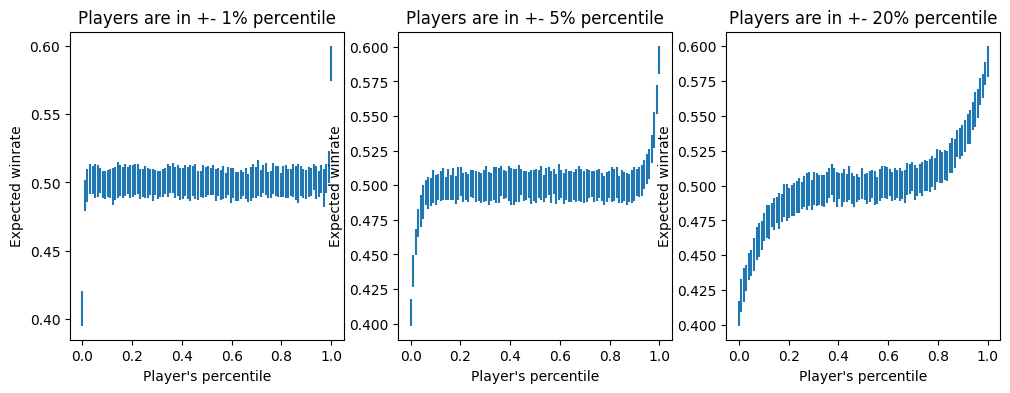

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('Players are in +- 1% percentile')
plot_simulation(simulate_winrate_gaussian_percentile, n_simulations=100000, n_steps=100, vicinity=0.01)
plt.subplot(132)
plt.title('Players are in +- 5% percentile')
plot_simulation(simulate_winrate_gaussian_percentile, n_simulations=100000, n_steps=100, vicinity=0.05)
plt.subplot(133)
plt.title('Players are in +- 20% percentile')
plot_simulation(simulate_winrate_gaussian_percentile, n_simulations=100000, n_steps=100, vicinity=0.2)

This is still a fair matchmaking, distributions are just a bit smoother due to gaussian proposal. So basically the winrate does not depend on the way we draw the allies/enemies as long as this is symmetric. But this still bother me, since it is a bit unrealistic, I'll might think of better modelling for this in the future. I would like to consider the repartition of players on division but I can't find this data >:c